In [4]:
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from IPython import display
import datetime
import time
from sklearn.model_selection import KFold

from utils import *
from deep_shadow import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


### Test with all data

In [6]:
dates = ['winter', 'spring', 'summer']
zoom = 16
shadow_path = 'data/shadows/'
height_path = 'data/heights_new/'

BATCH_SIZE = 1
TILES_PER_CITY = 790 # 95% of 790 is 750. The rest 40 are used for validation
STEPS = 40000

if not os.path.exists('results/'):
    os.mkdir('results/')

In [7]:
lat, dat = True, True # lat, dat true as we are using data from multiple cities and testing multiple dates!!

In [8]:
# Case: Uniform Distribution of Latitudes

train_cities = ['aus', 'par', 'syd', 'sp', 'mex', 'la', 'chi']
test_cities = ['dc', 'nyc', 'joh', 'bue', 'bos', 'sea', 'tok']

### Training

Time taken for 1000 steps: 96.30 sec



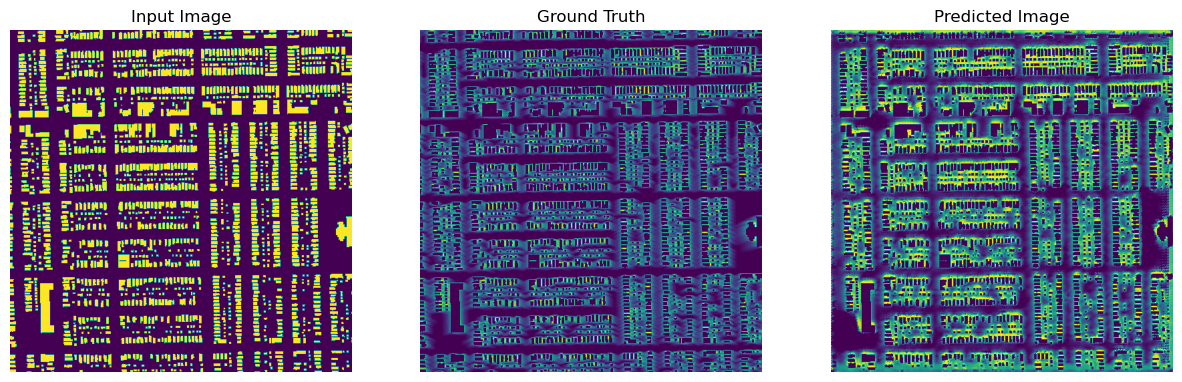

Step: 39k
custom_loss_func:  0.0579253919
gan_loss:  0.964929938
disc_loss:  1.20173061
....................................................................................................

In [7]:
# Training with -> different loss functions and resnet9 with and without attention

checkpoint_names = ['_l1', '_l2', '_l1_smooth', '_ssim_l1_smooth', '_ssim_l1'] # ['_ssim_with_sobel', '_ssim_sobel_plus_l1']
loss_functions = [[l1_loss], [l2_loss], [l1_smooth_loss], [ssim_loss, l1_smooth_loss], [ssim_loss, l1_loss]] # [ssim_loss, sobel_loss], [ssim_loss, sobel_loss, l1_loss]]

for i in range(len(checkpoint_names)):
    tf.keras.backend.clear_session()
    # down_stack, up_stack = get_generator_arch('resnet9', attn = True) # defined in utils
    down_stack, up_stack = get_generator_arch('resnet9', attn = False) # defined in utils

    train_dataset, validation_dataset = get_train_test(
        height_path, shadow_path, train_cities, dates, zoom, TILES_PER_CITY, BATCH_SIZE, train_size =  0.95)
    
    checkpoint_name = 'uniform_cities_resnet_wo_attn_' + checkpoint_names[i]
    checkpoint_path = 'training_checkpoints_new/%s' % (checkpoint_name)

    deep_shadow = DeepShadow(512, 512, down_stack, up_stack, latitude=lat, date=dat, loss_funcs=loss_functions[i], type='resnet9', attention=False, model_name=checkpoint_name)
    deep_shadow.fit(checkpoint_path, train_dataset, validation_dataset, STEPS)

In [2]:
# Training with best lost function from above (ssim + sobel):
# 1. unet with attention
# 2. unet without attention
# 3. resnet9 without attention

attn = [True, False, False]
gen = ['unet', 'unet', 'resnet9']

for i in range(len(attn)):
    tf.keras.backend.clear_session()
    down_stack, up_stack = get_generator_arch(gen[i], attn = attn[i])

    train_dataset, validation_dataset = get_train_test(
        height_path, shadow_path, train_cities, dates, zoom, TILES_PER_CITY, BATCH_SIZE, train_size =  0.95)
    
    str_attn = 'attn' if attn[i] else 'wo_attn'
    str_gen = 'unet' if gen[i] == 'unet' else 'resnet'
    checkpoint_name = 'uniform_cities_' + str_gen + '_' + str_attn + '__ssim_with_sobel_l1'
    checkpoint_path = 'training_checkpoints_new/%s' % (checkpoint_name)

    deep_shadow = DeepShadow(512, 512, down_stack, up_stack, latitude=lat, date=dat, loss_funcs=[ssim_loss, sobel_loss, l1_loss], type=gen[i], attention=attn[i], model_name=checkpoint_name)
    deep_shadow.fit(checkpoint_path, train_dataset, validation_dataset, STEPS)

### Store numeric results for all models

In [54]:
checkpoint_paths = glob.glob('training_checkpoints_new/*')

for i in range(len(checkpoint_paths)):
    tf.keras.backend.clear_session()

    # parse checkpoint name to get model type, attn, loss function
    checkpoint_name = checkpoint_names[i]
    _attn = False if 'wo_attn' in checkpoint_name else True
    gen = 'resnet9' if 'resnet' in checkpoint_name else 'unet'

    down_stack, up_stack = get_generator_arch(gen, attn = _attn)
    deep_shadow = DeepShadow(512, 512, down_stack, up_stack, latitude=lat, date=dat, type=gen, attention=_attn, model_name=checkpoint_name)
    deep_shadow.restore(checkpoint_paths[i])
    
    t_rmses, t_maes, t_mses, t_ssims, t_sobels = 0, 0, 0, 0, 0

    for city in test_cities:
        test = [city]
        test_dataset = get_tiles(height_path, shadow_path, test, dates, zoom, 750)
        test_dataset = test_to_tensor(test_dataset, BATCH_SIZE)

        df = pd.read_csv('data/compare_models_new/results_new_mask_height.csv')
        rmses, maes, mses, ssims,  sobels = get_metrics(test_dataset, deep_shadow.generator, latitude=lat, date=dat)
        df.loc[len(df.index)] = [checkpoint_name, city, np.average(maes), np.average(mses), np.average(rmses), np.average(ssims), np.average(sobels)] 
        df.to_csv('data/compare_models_new/results_new_mask_height.csv', index=False)

        t_rmses += np.average(rmses)
        t_maes += np.average(maes)
        t_mses += np.average(mses)
        t_ssims += np.average(ssims)
        t_sobels += np.average(sobels)
    
    print('\nAvg rmse: %.2f mae: %.2f mses: %.2f ssim: %.2f sobel: %.2f' 
          % (t_rmses/len(test_cities), t_maes/len(test_cities), t_mses/len(test_cities), 
             t_ssims/len(test_cities), t_sobels/len(test_cities)))
        

### Qualitative Evaluation

In [12]:
for i in range(len(checkpoint_paths)):
    tf.keras.backend.clear_session()

    # parse checkpoint name to get model type, attn, loss function
    checkpoint_name = checkpoint_names[i]
    _attn = False if 'wo_attn' in checkpoint_name else True
    gen = 'resnet9' if 'resnet' in checkpoint_name else 'unet'

    down_stack, up_stack = get_generator_arch(gen, attn = _attn)
    deep_shadow = DeepShadow(512, 512, down_stack, up_stack, latitude=lat, date=dat, loss_funcs=loss_functions[i], type=gen, attention=_attn, model_name=checkpoint_name)
    deep_shadow.restore(checkpoint_paths[i])
    
    for city in test_cities:
        test = [city]
        test_dataset = get_tiles(height_path, shadow_path, test, dates, zoom, 750)
        test_dataset = test_to_tensor(test_dataset, BATCH_SIZE)

        if not os.path.exists('data/compare_models_new/%s/%s' % (checkpoint_name, city)):
            os.makedirs('data/compare_models_new/%s/%s' % (checkpoint_name, city))

        df = pd.read_csv('data/tile_heights/%s-16.csv' %(city))
        df = df.sort_values(by=['height'], ascending=False)

        top = df.head(6)
        middle = df.iloc[len(df)//2-3:len(df)//2+3]
        bottom = df.tail(6)
        # concat
        all = pd.concat([top, middle, bottom])

        idx = 0
        for row in all.iterrows():
            i = int(row[1]['i'])
            j = int(row[1]['j'])

            if(idx < 2 or (idx > 5 and idx < 8) or (idx > 11 and idx < 14)): date = 'summer'
            elif((idx > 1 and idx < 4) or (idx > 7 and idx < 10) or (idx > 13 and idx < 16)): date = 'winter'
            else: date = 'spring'

            zoom = 16
            img_no = '%d_%d' % (i, j)

            plot_path = 'data/compare_models_new/%s/%s/%s_%s' % (checkpoint_name,city, img_no, date)
            test_on_image(deep_shadow.generator, height_path, shadow_path, city, date, zoom, i, j, path=plot_path, save=True)

            idx += 1

### 5 Fold Cross Validation: With Best Model

In [6]:

cities = ['la', 'bos', 'dc', 'nyc', 'chi', 'sp', 'bue',
          'joh', 'syd', 'tok', 'par', 'mex', 'sea', 'aus']

all_dataset = get_tiles(height_path, shadow_path, cities, dates, zoom, 400)
all_dataset = np.array(all_dataset)

checkpoint_name = 'kFold'
checkpoint_path = 'training_checkpoints_new/%s' % (checkpoint_name)

kf = KFold(n_splits=5, random_state=42, shuffle=True)

fold = 0
for train_index, test_index in kf.split(all_dataset):
    tf.keras.backend.clear_session()
    train_dataset = all_dataset[train_index]
    train_dataset = train_to_tensor(train_dataset, BATCH_SIZE)

    down_stack, up_stack = get_generator_arch('resnet9', attn = False)
    deep_shadow = DeepShadow(512, 512, down_stack, up_stack, latitude=True, date=True, loss_funcs=[ssim_loss, sobel_loss, l1_loss], type='resnet9', attention=False, model_name=checkpoint_name)
    deep_shadow.fit(checkpoint_path+'/fold_'+str(fold), train_dataset, None, STEPS)

    deep_shadow.restore(checkpoint_path+'/fold_'+str(fold))
    test_dataset = all_dataset[test_index]
    test_dataset = test_to_tensor(test_dataset, BATCH_SIZE)
    rmses, maes, mses, ssims, sobels = get_metrics(test_dataset, deep_shadow.generator, latitude=True, date=True)

    print('\nFold: %d rmse: %.2f mae: %.2f mse: %.2f ssim: %.2f sobel: %.2f ' %
          (fold, np.average(rmses), np.average(maes), np.average(mses), np.average(ssims), np.average(sobels)))
    df = pd.DataFrame({'rmse': rmses, 'mae': maes, 'mse': mses, 'ssim': ssims, 'sobel': sobels})

    filepath = 'results/%s-%d/fold_%d.csv' % (checkpoint_name, zoom, fold)
    if not os.path.exists(os.path.dirname(filepath)):
        os.mkdir(os.path.dirname(filepath))

    df.to_csv(filepath, index=False, header=True)

    fold += 1

Time taken for 1000 steps: 30.95 sec

Step: 39k
custom_loss_func:  0.522235513
gan_loss:  0.296910584
disc_loss:  1.76069379
....................................................................................................
Fold: 4 rmse: 0.06 mae: 0.03 mse: 0.01 ssim: 0.11 sobel: 0.04 


In [11]:
t_rmses, t_maes, t_mses, t_ssims, t_sobels = 0, 0, 0, 0, 0
for i in range(5):
    df = pd.read_csv('results/kFold-16/fold_%d.csv'%(i))
    t_rmses += np.average(df['rmse'])
    t_maes += np.average(df['mae'])
    t_mses += np.average(df['mse'])
    t_ssims += np.average(df['ssim'])
    t_sobels += np.average(df['sobel'])
    print('\nFold: %d rmse: %.4f mae: %.4f mse: %.4f ssim: %.2f sobel: %.4f ' %
            (i, np.average(df['rmse']), np.average(df['mae']), np.average(df['mse']), np.average(df['ssim']), np.average(df['sobel'])))

print('\nAvg rmse: %.4f mae: %.4f mse: %.4f ssim: %.2f sobel: %.4f ' %
        (t_rmses/5, t_maes/5, t_mses/5, t_ssims/5, t_sobels/5))


Fold: 0 rmse: 0.0603 mae: 0.0262 mse: 0.0059 ssim: 0.10 sobel: 0.0343 

Fold: 1 rmse: 0.0630 mae: 0.0279 mse: 0.0062 ssim: 0.10 sobel: 0.0361 

Fold: 2 rmse: 0.0619 mae: 0.0267 mse: 0.0060 ssim: 0.10 sobel: 0.0361 

Fold: 3 rmse: 0.0663 mae: 0.0290 mse: 0.0067 ssim: 0.11 sobel: 0.0384 

Fold: 4 rmse: 0.0641 mae: 0.0283 mse: 0.0065 ssim: 0.11 sobel: 0.0363 

Avg rmse: 0.0631 mae: 0.0276 mse: 0.0063 ssim: 0.10 sobel: 0.0362 
